In [35]:
%matplotlib notebook

import numpy as np
import pandas as pd
import netCDF4 as nc
import geopandas as gpd
import dask
import dask.array as da
import xarray as xr
import csv
from scipy.spatial import KDTree
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta

In [2]:
''' Coords of box '''
location = 1 # 0: Alatna, 1: Huslia, 

centers  = [[-153.65, 66.70], # Alatna (2, 3572)
            [-155.69, 66.01], # Huslia (2, 3612)
            [-157.01, 66.96], # (2, 3548)
            [-157.82, 65.81], # (2, 3630)
            [-158.34, 65.23], # (2, 3674)
            [-153.05, 67.12], # (2, 3537)
            [-152.30, 67.12], # (2, 3539)
            [-150.92, 66.71], # (2, 3568)
            [-146.44, 66.96], # (2, 3550) 
            [-153.26, 64.53]] # (2, 3728)

min_lon = centers[location][0] - .65
max_lon = centers[location][0] + .65
min_lat = centers[location][1] - .25
max_lat = centers[location][1] + .25

box_lon = np.array([min_lon, max_lon, max_lon, min_lon, min_lon])
box_lat = np.array([min_lat, min_lat, max_lat, max_lat, min_lat])

<IPython.core.display.Javascript object>


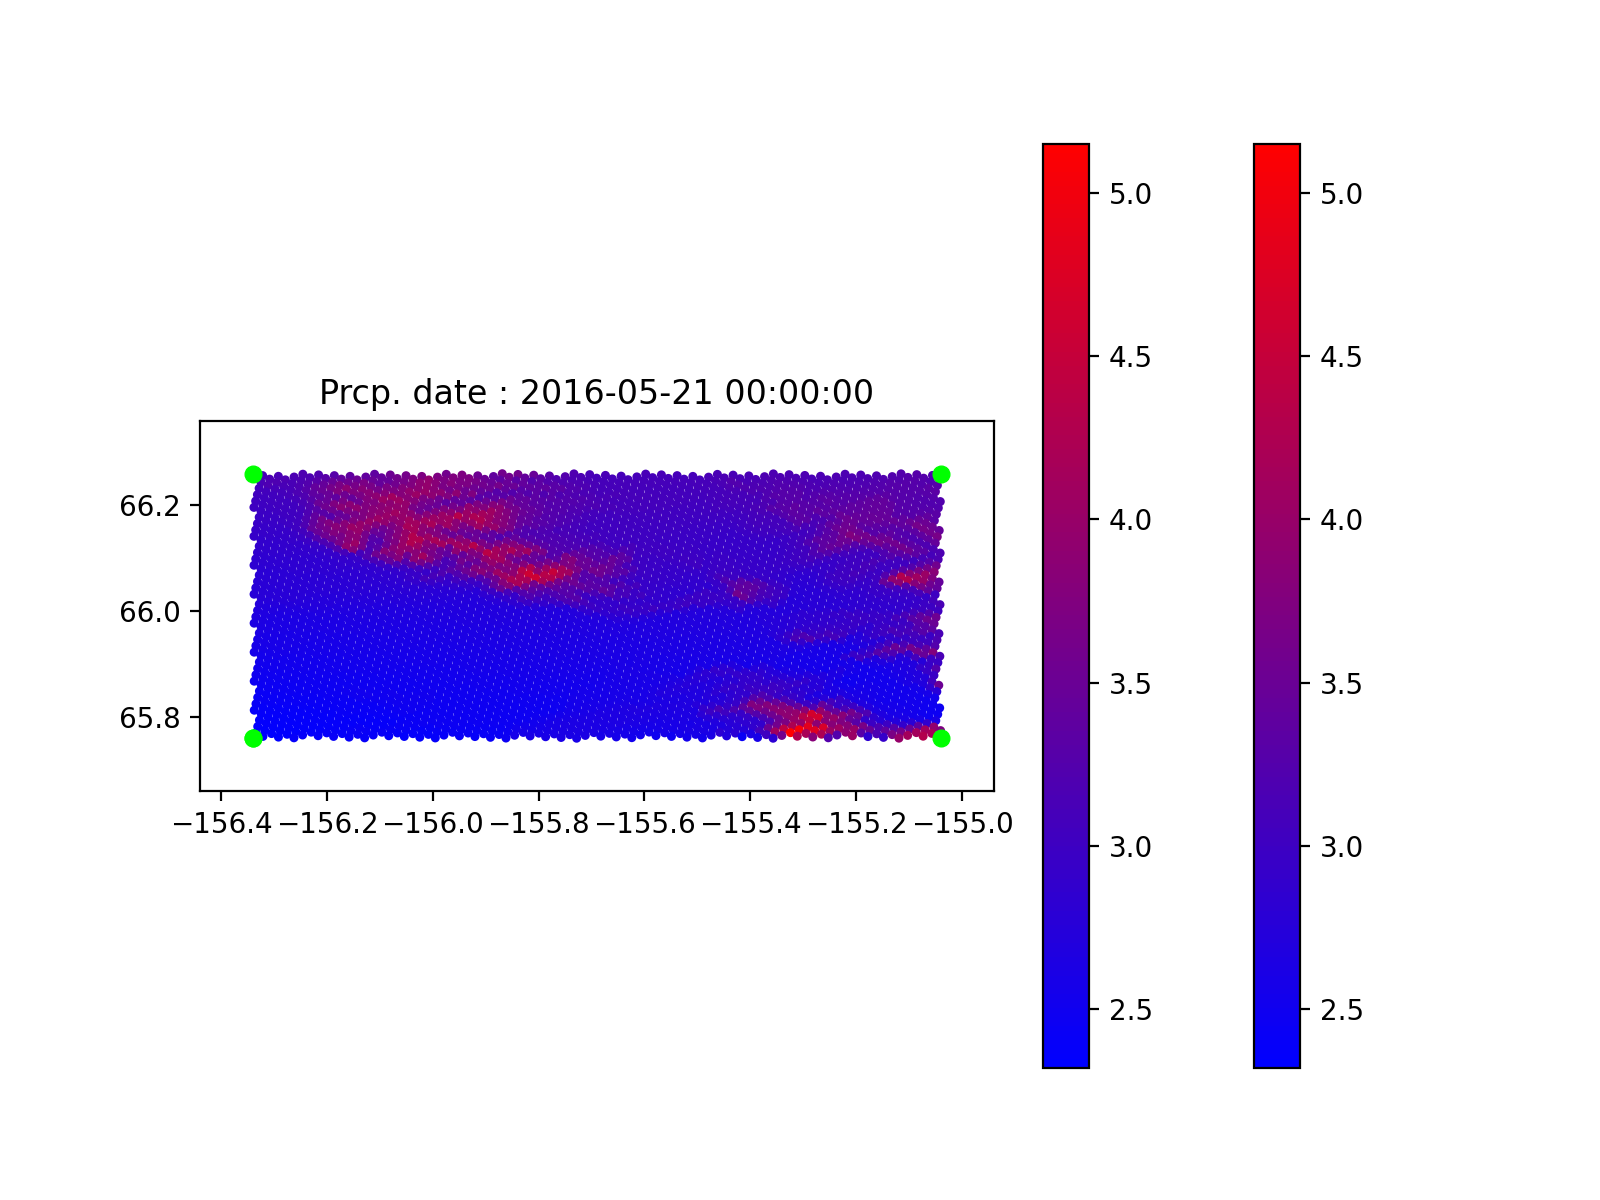

(65.66000000000001, 66.36)

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(min_lon - .1, max_lon + .1)
ax.set_ylim(min_lat - .1, max_lat + .1)

## Create a subset of the precip data inside a box

In [4]:
''' Get data '''
ds = xr.open_dataset("/Users/joshuamiller/Documents/SULI 2023/Data/DAYMET_Precip/daymet_v4_daily_na_prcp_2016.nc")

print("---------------------------------------------------")
print(ds.coords, " |", ds.prod, " |", ds.attrs)
print("---------------------------------------------------")
# Create Dask arrays for lat and lon
lat = da.from_array(ds["lat"].values, chunks=(1000, 1000))
lon = da.from_array(ds["lon"].values, chunks=(1000, 1000))
time = da.from_array(ds["time"].values, chunks=(365))
print("HERE")

print(type(lat))
#============================================================================================
# Use Dask to filter the lat and lon arrays
and_idx = np.array(np.where(np.logical_and(np.logical_and(lat >= min_lat, lat <= max_lat), 
                                           np.logical_and(lon >= min_lon, lon <= max_lon))))
#============================================================================================
# Compute the result and convert to numpy

time = time.compute()

print(time, np.shape(time)[0])

---------------------------------------------------
Coordinates:
  * x        (x) float32 -4.56e+06 -4.559e+06 -4.558e+06 ... 3.252e+06 3.253e+06
  * y        (y) float32 4.984e+06 4.983e+06 4.982e+06 ... -3.089e+06 -3.09e+06
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
  * time     (time) datetime64[ns] 2016-01-01T12:00:00 ... 2016-12-30T12:00:00  | <bound method DatasetAggregations.prod of <xarray.Dataset>
Dimensions:                  (x: 7814, y: 8075, time: 365, nv: 2)
Coordinates:
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * time                     (time) datetime64[ns] 2016-01-01T12:00:00 ... 20...
Dimensions without coordinates: nv
Data variables:
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    la

In [5]:
lon_and  = np.empty(np.shape(and_idx)[1], float)
lat_and  = np.empty(np.shape(and_idx)[1], float)

for i in range(np.shape(lon_and)[0]):
    lon_and_ds = ds['lon'][:, :] # Since lat and lon don't change between time measurements just use first timestep
    lat_and_ds = ds['lat'][:, :]
    
    lon_and[i] = lon_and_ds[and_idx[0][i]][and_idx[1][i]].compute()
    lat_and[i] = lat_and_ds[and_idx[0][i]][and_idx[1][i]].compute()

In [6]:
print(min(lon_and), max(lon_and), min(lat_and), max(lat_and))
print(min_lon, max_lon, min_lat, max_lat)

-156.338134765625 -155.04022216796875 65.76008605957031 66.26000213623047
-156.34 -155.04 65.76 66.26


In [7]:
''' Iterate through time and get prcp values in the big box '''
prcp_and = np.empty((np.shape(time)[0], np.shape(and_idx)[1]), float)

for t in range(np.shape(time)[0]):
    print("----------------------------------------------------------------------------")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ", t, " ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("----------------------------------------------------------------------------")
    new_prcp = ds['prcp'][t, :, :]
    print(np.shape(new_prcp))
    new_prcp_darray = da.from_array(new_prcp, chunks=(1000, 1000))
    print(type(new_prcp_darray), np.shape(new_prcp_darray))

    for i in range(np.shape(and_idx)[1]):
        prcp_and[t][i] = new_prcp_darray[and_idx[0][i]][and_idx[1][i]].compute().values

        #print("prcp =", new_prcp_darray[and_idx[0][i]][and_idx[1][i]].compute().values,
        #      ", lat =", new_prcp_darray[and_idx[0][i]][and_idx[1][i]].compute().lat.values,
        #      ", lon =", new_prcp_darray[and_idx[0][i]][and_idx[1][i]].compute().lon.values)

----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  0  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  1  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  2  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  3  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-------

----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  29  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  30  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  31  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  32  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
---

----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  58  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  59  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  60  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  61  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
---

----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  87  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  88  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  89  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  90  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
---

----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  116  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  117  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  118  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  119  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  145  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  146  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  147  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  148  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  174  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  175  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  176  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  177  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  203  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  204  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  205  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  206  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  232  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  233  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  234  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  235  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  261  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  262  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  263  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  264  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  290  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  291  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  292  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  293  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  319  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  320  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  321  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  322  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  348  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  349  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  350  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------
(8075, 7814)
<class 'dask.array.core.Array'> (8075, 7814)
----------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  351  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## Save this subset of the data as a .nc file

In [8]:
location_names = ['Alatna_Box', 'Huslia_Box', 'Loc1', 'Loc2', 'Loc3', 'Loc4', 'Loc5', 'Loc6', 'Loc7', 'Loc8']
lolol = ['Alatna', 'Huslia', 'Loc1', 'Loc2', 'Loc3', 'Loc4', 'Loc5', 'Loc6', 'Loc7', 'Loc8']

In [9]:
''' Write da file '''
#ncfile.close()
ncfile = nc.Dataset('/Users/joshuamiller/Documents/SULI 2023/Data/'+location_names[location]+'/Temp/tmin_2016_1_1-2016_12_31_'+lolol[location]+'_subset.nc', 'w', format='NETCDF4')

# Create dimensions
ncfile.createDimension('time', prcp_and.shape[0])
ncfile.createDimension('x', prcp_and.shape[1])

# Create variables
lat_var = ncfile.createVariable('lat', 'f4', ('x',))
lon_var = ncfile.createVariable('lon', 'f4', ('x',))
time_var = ncfile.createVariable('time', 'i4', ('time',)) # Orig. i4
prcp_var = ncfile.createVariable('prcp', 'f4', ('time','x'))

lat_var.setncattr('dimensions', 'x')
lon_var.setncattr('dimensions', 'x')
time_var.setncattr('dimensions', 'time')
prcp_var.setncattr('dimensions', 'time' 'x')

# Assign values to variables
lat_var[:] = lat_and
lon_var[:] = lon_and
time_var[:] = np.arange(0, prcp_and.shape[0]) # 0, 1, 2, ..., 364
prcp_var[:] = prcp_and

# Add variable attributes
lat_var.units = 'degrees north'
lon_var.units = 'degrees east'
time_var.units = 'days since 2016-01-01 00:00:00'
prcp_var.units = 'mm'

# Close the file
ncfile.close()

## Extract data for plotting

In [20]:
f = nc.Dataset('/Users/joshuamiller/Documents/SULI 2023/Data/'+location_names[location]+'/Temp/tmin_2016_1_1-2016_12_31_'+lolol[location]+'_subset.nc', "r")
print(f.dimensions.keys())

# Print the variables in the file
print(f.variables.keys())

lat_sub = f.variables["lat"] # Pointer to variable
lat_sub = np.array(lat_sub[:]) # : Extracts the numbers

lon_sub = f.variables["lon"]
lon_sub = np.array(lon_sub[:])

time = f.variables["time"]
time = np.array(time[:])

prcp_sub = f.variables["prcp"]
prcp_sub = np.array(prcp_sub[:])

f.close()

dict_keys(['time', 'x'])
dict_keys(['lat', 'lon', 'time', 'prcp'])


In [21]:
print(np.shape(lat_sub), np.shape(lon_sub), min(lat_sub.ravel()), max(lat_sub.ravel()), min(lon_sub.ravel()), max(lon_sub.ravel()), np.shape(prcp_sub))

(3616,) (3616,) 65.760086 66.26 -156.33813 -155.04022 (365, 3616)


In [22]:
''' Get points for the snow plot and box '''
points = [Point(xy) for xy in zip(lon_sub.ravel(), lat_sub.ravel())]
points_gdf = gpd.GeoDataFrame(geometry=points)

''' Corners of the box of interest '''
points_box = [Point(xy) for xy in zip(box_lon, box_lat)]
points_box_gdf = gpd.GeoDataFrame(geometry=points_box)

In [23]:
date = 141

prcp_sub_gdf = gpd.GeoDataFrame(geometry=points).assign(data=prcp_sub[date, :].ravel())

## Make the plot

In [24]:
''' Plot world outline '''
ak = gpd.read_file("/Users/joshuamiller/Desktop/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")

In [25]:
norm = Normalize(vmin=min(prcp_sub[date, :].ravel()), vmax=max(prcp_sub[date, :].ravel()))
cmap = LinearSegmentedColormap.from_list('custom', ['blue', 'red'], N=200) # Higher N=more smooth

In [26]:
ak.plot(ax=ax, color='white', edgecolor='black', linewidth=0.1, alpha=1) # GOOD lots the map

plt.draw()

In [27]:
prcp_sub_gdf.plot(ax=ax, column='data', cmap=cmap, norm=norm, markersize=5, alpha=1, legend=True)

plt.draw()

In [28]:
points_box_gdf.plot(ax=ax, color='lime', edgecolor='lime', linewidth=.5, alpha=1)

plt.draw()

In [29]:
end_date = datetime(2016, 1, 1) + timedelta(days=date)
ax.set_title("Prcp. date : " + str(end_date))

Text(0.5, 1.0, 'Prcp. date : 2016-05-21 00:00:00')

## Krig data to 70x50 rectangular grid

In [30]:
lon_linspace = np.linspace(min_lon, max_lon, 70)
lat_linspace = np.linspace(min_lat, max_lat, 50)

new_prcp = np.empty((np.shape(prcp_sub)[0], np.shape(lon_linspace)[0], np.shape(lat_linspace)[0]), float)
print(np.shape(lon_linspace), np.shape(lat_linspace), np.shape(new_prcp))

(70,) (50,) (365, 70, 50)


In [31]:
''' Create tree '''
print(np.array([lon_sub, lat_sub]).T.reshape(-1,2))

tree = KDTree(np.array([lon_sub, lat_sub]).T.reshape(-1,2))

[[-156.33813    66.25108 ]
 [-156.32162    66.25642 ]
 [-156.3249     66.24442 ]
 ...
 [-155.0567     65.76921 ]
 [-155.04022    65.77447 ]
 [-155.04391    65.762436]]


In [32]:
def DoKrig(x, y, val, x_target, y_target):
    OK = OrdinaryKriging(
                x, 
                y, 
                val, 
                variogram_model='spherical',
                verbose=False,
                enable_plotting=False,
                nlags=10,
                )
    return OK.execute("points", x_target, y_target)

In [33]:
num_neighbors = 5
new_lon = np.empty((np.shape(lon_linspace)[0],
                    np.shape(lat_linspace)[0]), float)
new_lat = np.empty((np.shape(lon_linspace)[0],
                    np.shape(lat_linspace)[0]), float)

In [36]:
for i in range(np.shape(new_prcp)[1]):
    for j in range(np.shape(new_prcp)[2]):
        print("-----------------", i, j, "------------------")
        
        ''' Start populating new_lon, new_lat '''
        new_lon[i][j] = lon_linspace[i]
        new_lat[i][j] = lat_linspace[j]
        
        ''' Get closest neighbor(s) to desired point in prcp '''
        target_point = np.array([lon_linspace[i], lat_linspace[j]])
    
        dis, idx = tree.query(target_point, k=num_neighbors)
    
        lon_krig = lon_sub[idx]
        lat_krig = lat_sub[idx]
    
        for t in range(np.shape(new_prcp)[0]):
            prcp_krig = prcp_sub[t][idx]
        
            if not (np.all(prcp_krig == prcp_krig[0])): # Array elements are different

                zstar, ss = DoKrig(lon_krig, lat_krig, prcp_krig, new_lon[i], new_lat[j])

                new_prcp[t][i][j] = zstar[0]
                #print("prcp_krig =", prcp_krig, ", new_prcp[t][i][j] =", round(new_prcp[t][i][j], 3),
                #     ", lon_krig =", lon_krig, ", target =", new_lon[i][j],
                #     ", lat_krig =", lat_krig, ", target =", new_lat[i][j])

            else: # All array elements are the same
                #print(prcp_krig[idx[0]])
                if not (-999 <= prcp_krig[0] and prcp_krig[0] <= 367):
                    #print("AHHHHHHH | prcp_krig =", prcp_krig, ", new_prcp[t][i] =", new_prcp[t][i])
                    new_prcp[t][i][j] = 0
                else:
                    new_prcp[t][i][j] = prcp_krig[0]
                    #print("prcp_krig =", prcp_krig, ", new_prcp[t][i] =", new_prcp[t][i])

            #print("z =", new_prcp[t][i], ", prcp =", prcp_krig, "i =", i, ", t =", t, ", idx =", idx, ", point =", point, " lon =", lon_krig, ", lat =", lat_krig)

----------------- 0 0 ------------------
----------------- 0 1 ------------------
----------------- 0 2 ------------------
----------------- 0 3 ------------------
----------------- 0 4 ------------------
----------------- 0 5 ------------------
----------------- 0 6 ------------------
----------------- 0 7 ------------------
----------------- 0 8 ------------------
----------------- 0 9 ------------------
----------------- 0 10 ------------------
----------------- 0 11 ------------------
----------------- 0 12 ------------------
----------------- 0 13 ------------------
----------------- 0 14 ------------------
----------------- 0 15 ------------------
----------------- 0 16 ------------------
----------------- 0 17 ------------------
----------------- 0 18 ------------------
----------------- 0 19 ------------------
----------------- 0 20 ------------------
----------------- 0 21 ------------------
----------------- 0 22 ------------------
----------------- 0 23 ------------------
--

----------------- 3 47 ------------------
----------------- 3 48 ------------------
----------------- 3 49 ------------------
----------------- 4 0 ------------------
----------------- 4 1 ------------------
----------------- 4 2 ------------------
----------------- 4 3 ------------------
----------------- 4 4 ------------------
----------------- 4 5 ------------------
----------------- 4 6 ------------------
----------------- 4 7 ------------------
----------------- 4 8 ------------------
----------------- 4 9 ------------------
----------------- 4 10 ------------------
----------------- 4 11 ------------------
----------------- 4 12 ------------------
----------------- 4 13 ------------------
----------------- 4 14 ------------------
----------------- 4 15 ------------------
----------------- 4 16 ------------------
----------------- 4 17 ------------------
----------------- 4 18 ------------------
----------------- 4 19 ------------------
----------------- 4 20 ------------------
--

----------------- 7 45 ------------------
----------------- 7 46 ------------------
----------------- 7 47 ------------------
----------------- 7 48 ------------------
----------------- 7 49 ------------------
----------------- 8 0 ------------------
----------------- 8 1 ------------------
----------------- 8 2 ------------------
----------------- 8 3 ------------------
----------------- 8 4 ------------------
----------------- 8 5 ------------------
----------------- 8 6 ------------------
----------------- 8 7 ------------------
----------------- 8 8 ------------------
----------------- 8 9 ------------------
----------------- 8 10 ------------------
----------------- 8 11 ------------------
----------------- 8 12 ------------------
----------------- 8 13 ------------------
----------------- 8 14 ------------------
----------------- 8 15 ------------------
----------------- 8 16 ------------------
----------------- 8 17 ------------------
----------------- 8 18 ------------------
--

----------------- 11 39 ------------------
----------------- 11 40 ------------------
----------------- 11 41 ------------------
----------------- 11 42 ------------------
----------------- 11 43 ------------------
----------------- 11 44 ------------------
----------------- 11 45 ------------------
----------------- 11 46 ------------------
----------------- 11 47 ------------------
----------------- 11 48 ------------------
----------------- 11 49 ------------------
----------------- 12 0 ------------------
----------------- 12 1 ------------------
----------------- 12 2 ------------------
----------------- 12 3 ------------------
----------------- 12 4 ------------------
----------------- 12 5 ------------------
----------------- 12 6 ------------------
----------------- 12 7 ------------------
----------------- 12 8 ------------------
----------------- 12 9 ------------------
----------------- 12 10 ------------------
----------------- 12 11 ------------------
----------------- 12 

----------------- 15 31 ------------------
----------------- 15 32 ------------------
----------------- 15 33 ------------------
----------------- 15 34 ------------------
----------------- 15 35 ------------------
----------------- 15 36 ------------------
----------------- 15 37 ------------------
----------------- 15 38 ------------------
----------------- 15 39 ------------------
----------------- 15 40 ------------------
----------------- 15 41 ------------------
----------------- 15 42 ------------------
----------------- 15 43 ------------------
----------------- 15 44 ------------------
----------------- 15 45 ------------------
----------------- 15 46 ------------------
----------------- 15 47 ------------------
----------------- 15 48 ------------------
----------------- 15 49 ------------------
----------------- 16 0 ------------------
----------------- 16 1 ------------------
----------------- 16 2 ------------------
----------------- 16 3 ------------------
---------------

----------------- 19 23 ------------------
----------------- 19 24 ------------------
----------------- 19 25 ------------------
----------------- 19 26 ------------------
----------------- 19 27 ------------------
----------------- 19 28 ------------------
----------------- 19 29 ------------------
----------------- 19 30 ------------------
----------------- 19 31 ------------------
----------------- 19 32 ------------------
----------------- 19 33 ------------------
----------------- 19 34 ------------------
----------------- 19 35 ------------------
----------------- 19 36 ------------------
----------------- 19 37 ------------------
----------------- 19 38 ------------------
----------------- 19 39 ------------------
----------------- 19 40 ------------------
----------------- 19 41 ------------------
----------------- 19 42 ------------------
----------------- 19 43 ------------------
----------------- 19 44 ------------------
----------------- 19 45 ------------------
-----------

----------------- 23 16 ------------------
----------------- 23 17 ------------------
----------------- 23 18 ------------------
----------------- 23 19 ------------------
----------------- 23 20 ------------------
----------------- 23 21 ------------------
----------------- 23 22 ------------------
----------------- 23 23 ------------------
----------------- 23 24 ------------------
----------------- 23 25 ------------------
----------------- 23 26 ------------------
----------------- 23 27 ------------------
----------------- 23 28 ------------------
----------------- 23 29 ------------------
----------------- 23 30 ------------------
----------------- 23 31 ------------------
----------------- 23 32 ------------------
----------------- 23 33 ------------------
----------------- 23 34 ------------------
----------------- 23 35 ------------------
----------------- 23 36 ------------------
----------------- 23 37 ------------------
----------------- 23 38 ------------------
-----------

----------------- 27 9 ------------------
----------------- 27 10 ------------------
----------------- 27 11 ------------------
----------------- 27 12 ------------------
----------------- 27 13 ------------------
----------------- 27 14 ------------------
----------------- 27 15 ------------------
----------------- 27 16 ------------------
----------------- 27 17 ------------------
----------------- 27 18 ------------------
----------------- 27 19 ------------------
----------------- 27 20 ------------------
----------------- 27 21 ------------------
----------------- 27 22 ------------------
----------------- 27 23 ------------------
----------------- 27 24 ------------------
----------------- 27 25 ------------------
----------------- 27 26 ------------------
----------------- 27 27 ------------------
----------------- 27 28 ------------------
----------------- 27 29 ------------------
----------------- 27 30 ------------------
----------------- 27 31 ------------------
------------

----------------- 31 1 ------------------
----------------- 31 2 ------------------
----------------- 31 3 ------------------
----------------- 31 4 ------------------
----------------- 31 5 ------------------
----------------- 31 6 ------------------
----------------- 31 7 ------------------
----------------- 31 8 ------------------
----------------- 31 9 ------------------
----------------- 31 10 ------------------
----------------- 31 11 ------------------
----------------- 31 12 ------------------
----------------- 31 13 ------------------
----------------- 31 14 ------------------
----------------- 31 15 ------------------
----------------- 31 16 ------------------
----------------- 31 17 ------------------
----------------- 31 18 ------------------
----------------- 31 19 ------------------
----------------- 31 20 ------------------
----------------- 31 21 ------------------
----------------- 31 22 ------------------
----------------- 31 23 ------------------
----------------- 31

----------------- 34 43 ------------------
----------------- 34 44 ------------------
----------------- 34 45 ------------------
----------------- 34 46 ------------------
----------------- 34 47 ------------------
----------------- 34 48 ------------------
----------------- 34 49 ------------------
----------------- 35 0 ------------------
----------------- 35 1 ------------------
----------------- 35 2 ------------------
----------------- 35 3 ------------------
----------------- 35 4 ------------------
----------------- 35 5 ------------------
----------------- 35 6 ------------------
----------------- 35 7 ------------------
----------------- 35 8 ------------------
----------------- 35 9 ------------------
----------------- 35 10 ------------------
----------------- 35 11 ------------------
----------------- 35 12 ------------------
----------------- 35 13 ------------------
----------------- 35 14 ------------------
----------------- 35 15 ------------------
----------------- 35 

----------------- 38 35 ------------------
----------------- 38 36 ------------------
----------------- 38 37 ------------------
----------------- 38 38 ------------------
----------------- 38 39 ------------------
----------------- 38 40 ------------------
----------------- 38 41 ------------------
----------------- 38 42 ------------------
----------------- 38 43 ------------------
----------------- 38 44 ------------------
----------------- 38 45 ------------------
----------------- 38 46 ------------------
----------------- 38 47 ------------------
----------------- 38 48 ------------------
----------------- 38 49 ------------------
----------------- 39 0 ------------------
----------------- 39 1 ------------------
----------------- 39 2 ------------------
----------------- 39 3 ------------------
----------------- 39 4 ------------------
----------------- 39 5 ------------------
----------------- 39 6 ------------------
----------------- 39 7 ------------------
----------------- 3

----------------- 42 27 ------------------
----------------- 42 28 ------------------
----------------- 42 29 ------------------
----------------- 42 30 ------------------
----------------- 42 31 ------------------
----------------- 42 32 ------------------
----------------- 42 33 ------------------
----------------- 42 34 ------------------
----------------- 42 35 ------------------
----------------- 42 36 ------------------
----------------- 42 37 ------------------
----------------- 42 38 ------------------
----------------- 42 39 ------------------
----------------- 42 40 ------------------
----------------- 42 41 ------------------
----------------- 42 42 ------------------
----------------- 42 43 ------------------
----------------- 42 44 ------------------
----------------- 42 45 ------------------
----------------- 42 46 ------------------
----------------- 42 47 ------------------
----------------- 42 48 ------------------
----------------- 42 49 ------------------
-----------

----------------- 46 20 ------------------
----------------- 46 21 ------------------
----------------- 46 22 ------------------
----------------- 46 23 ------------------
----------------- 46 24 ------------------
----------------- 46 25 ------------------
----------------- 46 26 ------------------
----------------- 46 27 ------------------
----------------- 46 28 ------------------
----------------- 46 29 ------------------
----------------- 46 30 ------------------
----------------- 46 31 ------------------
----------------- 46 32 ------------------
----------------- 46 33 ------------------
----------------- 46 34 ------------------
----------------- 46 35 ------------------
----------------- 46 36 ------------------
----------------- 46 37 ------------------
----------------- 46 38 ------------------
----------------- 46 39 ------------------
----------------- 46 40 ------------------
----------------- 46 41 ------------------
----------------- 46 42 ------------------
-----------

----------------- 50 12 ------------------
----------------- 50 13 ------------------
----------------- 50 14 ------------------
----------------- 50 15 ------------------
----------------- 50 16 ------------------
----------------- 50 17 ------------------
----------------- 50 18 ------------------
----------------- 50 19 ------------------
----------------- 50 20 ------------------
----------------- 50 21 ------------------
----------------- 50 22 ------------------
----------------- 50 23 ------------------
----------------- 50 24 ------------------
----------------- 50 25 ------------------
----------------- 50 26 ------------------
----------------- 50 27 ------------------
----------------- 50 28 ------------------
----------------- 50 29 ------------------
----------------- 50 30 ------------------
----------------- 50 31 ------------------
----------------- 50 32 ------------------
----------------- 50 33 ------------------
----------------- 50 34 ------------------
-----------

----------------- 54 4 ------------------
----------------- 54 5 ------------------
----------------- 54 6 ------------------
----------------- 54 7 ------------------
----------------- 54 8 ------------------
----------------- 54 9 ------------------
----------------- 54 10 ------------------
----------------- 54 11 ------------------
----------------- 54 12 ------------------
----------------- 54 13 ------------------
----------------- 54 14 ------------------
----------------- 54 15 ------------------
----------------- 54 16 ------------------
----------------- 54 17 ------------------
----------------- 54 18 ------------------
----------------- 54 19 ------------------
----------------- 54 20 ------------------
----------------- 54 21 ------------------
----------------- 54 22 ------------------
----------------- 54 23 ------------------
----------------- 54 24 ------------------
----------------- 54 25 ------------------
----------------- 54 26 ------------------
-----------------

----------------- 57 46 ------------------
----------------- 57 47 ------------------
----------------- 57 48 ------------------
----------------- 57 49 ------------------
----------------- 58 0 ------------------
----------------- 58 1 ------------------
----------------- 58 2 ------------------
----------------- 58 3 ------------------
----------------- 58 4 ------------------
----------------- 58 5 ------------------
----------------- 58 6 ------------------
----------------- 58 7 ------------------
----------------- 58 8 ------------------
----------------- 58 9 ------------------
----------------- 58 10 ------------------
----------------- 58 11 ------------------
----------------- 58 12 ------------------
----------------- 58 13 ------------------
----------------- 58 14 ------------------
----------------- 58 15 ------------------
----------------- 58 16 ------------------
----------------- 58 17 ------------------
----------------- 58 18 ------------------
----------------- 58 

----------------- 61 38 ------------------
----------------- 61 39 ------------------
----------------- 61 40 ------------------
----------------- 61 41 ------------------
----------------- 61 42 ------------------
----------------- 61 43 ------------------
----------------- 61 44 ------------------
----------------- 61 45 ------------------
----------------- 61 46 ------------------
----------------- 61 47 ------------------
----------------- 61 48 ------------------
----------------- 61 49 ------------------
----------------- 62 0 ------------------
----------------- 62 1 ------------------
----------------- 62 2 ------------------
----------------- 62 3 ------------------
----------------- 62 4 ------------------
----------------- 62 5 ------------------
----------------- 62 6 ------------------
----------------- 62 7 ------------------
----------------- 62 8 ------------------
----------------- 62 9 ------------------
----------------- 62 10 ------------------
----------------- 62 

----------------- 65 30 ------------------
----------------- 65 31 ------------------
----------------- 65 32 ------------------
----------------- 65 33 ------------------
----------------- 65 34 ------------------
----------------- 65 35 ------------------
----------------- 65 36 ------------------
----------------- 65 37 ------------------
----------------- 65 38 ------------------
----------------- 65 39 ------------------
----------------- 65 40 ------------------
----------------- 65 41 ------------------
----------------- 65 42 ------------------
----------------- 65 43 ------------------
----------------- 65 44 ------------------
----------------- 65 45 ------------------
----------------- 65 46 ------------------
----------------- 65 47 ------------------
----------------- 65 48 ------------------
----------------- 65 49 ------------------
----------------- 66 0 ------------------
----------------- 66 1 ------------------
----------------- 66 2 ------------------
--------------

----------------- 69 22 ------------------
----------------- 69 23 ------------------
----------------- 69 24 ------------------
----------------- 69 25 ------------------
----------------- 69 26 ------------------
----------------- 69 27 ------------------
----------------- 69 28 ------------------
----------------- 69 29 ------------------
----------------- 69 30 ------------------
----------------- 69 31 ------------------
----------------- 69 32 ------------------
----------------- 69 33 ------------------
----------------- 69 34 ------------------
----------------- 69 35 ------------------
----------------- 69 36 ------------------
----------------- 69 37 ------------------
----------------- 69 38 ------------------
----------------- 69 39 ------------------
----------------- 69 40 ------------------
----------------- 69 41 ------------------
----------------- 69 42 ------------------
----------------- 69 43 ------------------
----------------- 69 44 ------------------
-----------

## Save as .nc file

In [ ]:
#ncfile.close()
ncfile = nc.Dataset('/Users/joshuamiller/Documents/SULI 2023/Data/'+location_names[location]+'/Precip/prcp_2016_1_1-2016_12_31_'+lolol[location]+'_krig_grid.nc', 'w', format='NETCDF4')

# Create dimensions
ncfile.createDimension('time', new_prcp.shape[0])
ncfile.createDimension('x', new_prcp.shape[1])
ncfile.createDimension('y', new_prcp.shape[2])

# Create variables
lat_var = ncfile.createVariable('lat', 'f4', ('x', 'y'))
lon_var = ncfile.createVariable('lon', 'f4', ('x','y'))
time_var = ncfile.createVariable('time', 'i4', ('time',)) # Orig. i4
prcp_var = ncfile.createVariable('prcp', 'f4', ('time','x','y'))

lat_var.setncattr('dimensions', 'x' 'y')
lon_var.setncattr('dimensions', 'x' 'y')
time_var.setncattr('dimensions', 'time')
prcp_var.setncattr('dimensions', 'time' 'x' 'y')

# Assign values to variables
lat_var[:] = new_lat
lon_var[:] = new_lon
time_var[:] = np.arange(0, prcp_and.shape[0]) # 0, 1, 2, ..., 364
prcp_var[:] = new_prcp

# Add variable attributes
lat_var.units = 'degrees north'
lon_var.units = 'degrees east'
time_var.units = 'days since 2016-01-01 00:00:00'
prcp_var.units = 'C'

# Close the file
ncfile.close()

In [ ]:
f = nc.Dataset('/Users/joshuamiller/Documents/SULI 2023/Data/'+location_names[location]+'/Precip/prcp_2016_1_1-2016_12_31_'+lolol[location]+'_krig_grid.nc', "r")
print(f.dimensions.keys())

# Print the variables in the file
print(f.variables.keys())

lat_grid = f.variables["lat"] # Pointer to variable
lat_grid = np.array(lat_grid[:]) # : Extracts the numbers

lon_grid = f.variables["lon"]
lon_grid = np.array(lon_grid[:])

time = f.variables["time"]
time = np.array(time[:])

prcp_grid = f.variables["prcp"]
prcp_grid = np.array(prcp_grid[:])

f.close()

In [ ]:
print('SAVED FILE : /Users/joshuamiller/Documents/SULI 2023/Data/'+location_names[location]+'/Precip/prcp_2016_1_1-2016_12_31_'+lolol[location]+'_krig_grid.nc')

## Plot to check

In [ ]:
''' Get points for the tmax plot and box '''
new_points = [Point(xy) for xy in zip(lon_grid.ravel(), lat_grid.ravel())]
points_gdf = gpd.GeoDataFrame(geometry=new_points)

In [ ]:
prcp_grid_gdf = gpd.GeoDataFrame(geometry=new_points).assign(data=prcp_grid[date, :, :].ravel())

prcp_grid_gdf.crs = {'proj': 'lcc',
           'lat_1': 25,
           'lat_2': 60,
           'lat_0': 42.5,
           'lon_0': -95,
           'x_0': 0,
           'y_0': 0,
           'ellps': 'WGS84',
           'datum': 'WGS84',
           'units': 'm',
           'no_defs': True}

In [ ]:
norm_grid = Normalize(vmin=min(prcp_grid[date, :, :].ravel()), vmax=max(prcp_grid[date, :, :].ravel()))
cmap_grid = LinearSegmentedColormap.from_list('custom', ['blue', 'red'], N=200) # Higher N=more smooth

In [ ]:
prcp_grid_gdf.plot(ax=ax[1], column='data', cmap=cmap_grid, norm=norm_grid, marker='s', markersize=10, alpha=1, legend=True)

plt.draw()

In [ ]:
fig.savefig('/Users/joshuamiller/Documents/SULI 2023/Data/'+location_names[location]+'/Precip/prcp_2016_1_1-2016_12_31_'+lolol[location]+'_krig_grid.pdf',
            bbox_inches = 'tight', pad_inches = 0)


In [ ]:
print('SAVED FIGURE : /Users/joshuamiller/Documents/SULI 2023/Data/'+location_names[location]+'/Precip/prcp_2016_1_1-2016_12_31_'+lolol[location]+'_krig_grid.pdf')